In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [24]:
from itertools import chain

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
import eli5
from typing import List
import nltk
from nltk import pos_tag
import emoji
import re
import random


In [25]:
nltk.corpus.conll2002.fileids()
train_sents = list(nltk.corpus.conll2002.iob_sents('esp.train'))
test_sents = list(nltk.corpus.conll2002.iob_sents('esp.testb'))
test_sents[0]

[('La', 'DA', 'B-LOC'),
 ('Coruña', 'NC', 'I-LOC'),
 (',', 'Fc', 'O'),
 ('23', 'Z', 'O'),
 ('may', 'NC', 'O'),
 ('(', 'Fpa', 'O'),
 ('EFECOM', 'NP', 'B-ORG'),
 (')', 'Fpt', 'O'),
 ('.', 'Fp', 'O')]

In [26]:
def remove_emojies(text):
    return emoji.get_emoji_regexp().sub(r'', text)

def remove_paranthese(text):
    return text.replace('(','').replace(')','').replace('[','').replace(']','').replace('?','').replace('!','').replace(',','').replace('"','').rstrip('\.')

In [27]:
DATA_FOLDER = '../data/'
DATA_FILE = 'oracle.csv'

In [28]:
def iob_tag(pos_tagged_tokens, entity, entity_type):
    entity_found = False
    iob_tagged_tokens = []
    
    for token in pos_tagged_tokens:
        if token[0] == entity:
            entity_found = True
            iob_tagged_tokens.append((token[0], token[1], entity_type))
        else:
            iob_tagged_tokens.append((token[0], token[1], 'O'))
    
    if not entity_found:
        print(f'didn\t find an entity {entity} in\n{[token[0] for token in pos_tagged_tokens]}')
    return iob_tagged_tokens

In [29]:
def prepare_text(text, entity, entity_type):
    tokens = [token.rstrip('\.').rstrip('\:').strip('\'') for token in text.split()]
    
    pos_tags = pos_tag(tokens)
    return iob_tag(pos_tags, entity, entity_type)

In [30]:
oracle: pd.DataFrame = pd.read_csv(DATA_FOLDER+DATA_FILE)

# remove emojies
oracle['body'] = oracle['body'].apply(remove_emojies)
oracle['body'] = oracle['body'].apply(lambda txt : txt.replace(',',""))
oracle['body'] = oracle['body'].apply(remove_paranthese)

# Change entitiy types to be appropriate for IOB tagging
oracle['entity type'].replace({'branch_name': 'B-BRANCH', 'file_name': 'B-FILE', 'issue_number': 'B-ISSUE'}, inplace=True)

# remove whitespace from beginning and end of the strings 
oracle['entity'] = oracle['entity'].str.strip()

# text_and_entities = oracle[['body', 'entity type', 'entity']]
print(oracle[oracle['entity type']=='B-ISSUE'])

                 project                                                url  \
300   angular/angular.js  https://github.com/angular/angular.js/issues/1...   
301   angular/angular.js  https://github.com/angular/angular.js/issues/1...   
302   angular/angular.js  https://github.com/angular/angular.js/issues/1...   
303   angular/angular.js  https://github.com/angular/angular.js/issues/1...   
304   angular/angular.js  https://github.com/angular/angular.js/issues/1...   
..                   ...                                                ...   
445  ytdl-org/youtube-dl  https://github.com/ytdl-org/youtube-dl/pull/25...   
446  ytdl-org/youtube-dl  https://github.com/ytdl-org/youtube-dl/pull/25...   
447  ytdl-org/youtube-dl  https://github.com/ytdl-org/youtube-dl/pull/84...   
448  ytdl-org/youtube-dl  https://github.com/ytdl-org/youtube-dl/pull/25...   
449  ytdl-org/youtube-dl  https://github.com/ytdl-org/youtube-dl/pull/27...   

    entity type                                    

In [31]:
processed_data = []
for idx, row in oracle.iterrows():
    processed_data.append(prepare_text(row['body'], row['entity'], row['entity type']))

random.shuffle(processed_data)

didn	 find an entity joh/feco in
['Sure', "it's", 'all', 'in', 'the', 'joh/feco-branch', 'There', 'is', 'a', 'new', 'decoration', 'service', 'which', 'uses', 'providers', 'for', 'the', 'actual', 'data', 'On', 'the', 'consuming', 'side', 'is', 'the', 'file', 'label', 'that', 'we', 'use', 'for', 'rendering', 'file', 'names']
didn	 find an entity dry-run-test in
['Change', 'into', 'the', 'root', 'of', 'the', 'moby-fork', 'repository', 'And', 'change', 'to', 'dry-run-test`', 'branch', 'perform', 'the', 'make', 'BIND_DIR=', 'shell', 'command', 'to', 'build', 'a', 'development', 'environment', 'image', 'and', 'run', 'it', 'in', 'a', 'container']
didn	 find an entity master in
['Same', 'for', 'me', 'in', 'master-branch', 'yesterday', 'I', 'tried', 'the', 'setting', 'debug', 'I', 'tried', 'to', 'get', 'detailed', 'logs', 'because', 'settings', "didn't", 'open']
didn	 find an entity UnitConverter plugin in
['When', 'building', 'the', 'local', 'clone', 'of', 'UnitConverter', 'plugin', 'branch', 

In [32]:
%%time
train_sents = processed_data[:350]
test_sents = processed_data[350:]
print(len(test_sents))

100
Wall time: 18 ms


In [33]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],        
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True
        
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True
                
    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [34]:
%%time
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

Wall time: 39 ms


In [35]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    c1=0.1, 
    c2=0.1, 
    max_iterations=100, 
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

Wall time: 740 ms


c:\users\q0ha\documents\repos\ml_project\venv\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

In [36]:
eli5.show_weights(crf, top=30)

In [37]:
labels = list(crf.classes_)
labels.remove('O')
labels

['B-FILE', 'B-BRANCH', 'B-ISSUE']

In [38]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred,
                      average='weighted', labels=labels)

0.26968845066743213

In [39]:
# group B and I results
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

    B-BRANCH      0.571     0.375     0.453        32
      B-FILE      0.412     0.206     0.275        34
     B-ISSUE      0.333     0.057     0.098        35

   micro avg      0.477     0.208     0.290       101
   macro avg      0.439     0.213     0.275       101
weighted avg      0.435     0.208     0.270       101



c:\users\q0ha\documents\repos\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=['B-BRANCH', 'B-FILE', 'B-ISSUE'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [43]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=5,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=100,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   42.1s finished


Wall time: 43 s


RandomizedSearchCV(cv=5,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 keep_tempfiles=None, max_iterations=100),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021C25B4DF70>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021C25B4DD60>},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['B-FILE', 'B-BRANCH', 'B-ISSUE']),
                   verbose=1)

In [44]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.5860327015865385, 'c2': 0.04114012596884718}
best CV score: 0.33610508432361447
model size: 0.06M


In [45]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

    B-BRANCH      0.722     0.406     0.520        32
      B-FILE      0.778     0.206     0.326        34
     B-ISSUE      0.500     0.086     0.146        35

   micro avg      0.697     0.228     0.343       101
   macro avg      0.667     0.233     0.331       101
weighted avg      0.664     0.228     0.325       101



In [51]:
rs.cv_results_

{'mean_fit_time': array([1.27381549, 1.09020782, 1.1262248 , 1.07891321, 1.26950154,
        1.05591931, 1.37080255, 1.10879893, 1.32899952, 1.16739802,
        1.1923974 , 1.33979874, 1.23799958, 1.19099631, 1.21619754,
        1.07699809, 1.08499517, 1.29459662, 1.08159814, 1.20259666,
        1.05819745, 1.33559947, 1.36279769, 1.29259839, 1.11879668,
        1.15979838, 1.19619679, 1.24499869, 1.33339729, 1.10619674,
        1.24839878, 1.05819707, 1.18339624, 1.07199907, 1.15599642,
        1.12299891, 1.13399639, 1.21279788, 1.04479728, 1.1547987 ,
        1.08859677, 1.09759641, 1.31399841, 1.30719776, 1.0989975 ,
        1.07779655, 1.14139714, 1.16659918, 1.45399952, 1.12879858,
        1.20939589, 1.11239743, 1.17839828, 1.08979807, 1.2743989 ,
        1.30339856, 1.066399  , 1.34899821, 1.0967978 , 1.14519801,
        1.13299737, 1.25179772, 1.20119843, 1.29499836, 1.13659859,
        1.06819811, 1.46879787, 1.1703979 , 1.07799807, 1.53559732,
        1.07739897, 1.28279796,

Dark blue => 0.2266, dark red => 0.3361


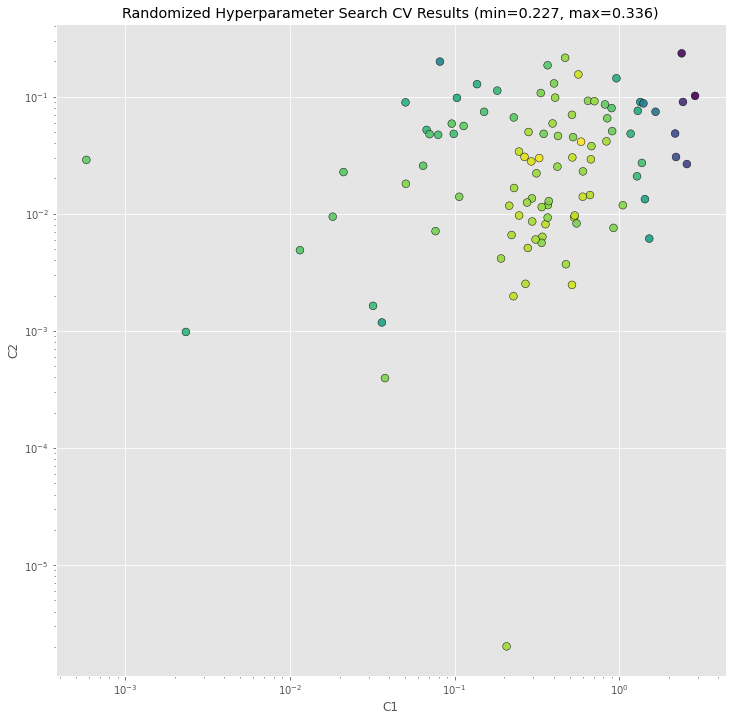

In [54]:
# _x = [s.parameters['c1'] for s in rs.grid_scores_]
# _y = [s.parameters['c2'] for s in rs.grid_scores_]
# _c = [s.mean_validation_score for s in rs.grid_scores_]

_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = [s for s in rs.cv_results_['mean_test_score']]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))